In [96]:
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta
import time
import csv
import re

# 設置 Selenium 驅動
options = Options()
options.add_argument("--headless")  # 如果需要顯示瀏覽器，請去掉此行
service = Service("/opt/homebrew/bin/chromedriver")  # 指定 ChromeDriver 的路徑
driver = webdriver.Chrome(service=service, options=options)

# 打開 Google Travel 的航班頁面
url = "https://www.google.com/travel/flights/search?tfs=CBwQAholEgoyMDI0LTEyLTIwKAFqDAgCEggvbS8wZnRreHIHCAESA1NZREABSAFwAYIBCwj___________8BmAEC&tfu=EgYIARABGAA&authuser=0"
driver.get(url)

# 等待頁面完全加載
flight_links = WebDriverWait(driver, 20).until(
    EC.presence_of_all_elements_located((By.CSS_SELECTOR, "li.pIav2d"))
)
print(f"找到 {len(flight_links)} 個航班")

# 設置一個計數器來記錄抓取成功的航班數量
success_count = 0

# 準備寫入 CSV 檔案（覆寫模式）
with open('google_flights_data_syd_1220.csv', 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)

    # 寫入標題
    csv_writer.writerow([
        "出發日期", "出發時間", "出發機場代號", 
        "抵達時間", "抵達機場代號", "航空公司", 
        "停靠站數量", "停留時間", "飛行時間", 
        "是否過夜", "機型", "航班代碼", "艙等", "價格歷史"
    ])

    # 遍歷並點擊每個航班列表項，打開新頁面
    for index in range(len(flight_links)):
        # 重新獲取航班連結，防止 StaleElementReferenceException
        flight_links = driver.find_elements(By.CSS_SELECTOR, "li.pIav2d")
        
        # 檢查是否超出範圍
        if index >= len(flight_links):
            print(f"索引 {index} 超出範圍，停止操作")
            break
        
        # 點擊
        flight_links[index].click()

        # 等待新頁面加載
        time.sleep(5)

        # 初始化各個欄位
        departure_date, departure_time, arrival_time, departure_airport, arrival_airport = "null", "null", "null", "null", "null"
        airline, layover, layover_time, flight_duration, overnight, aircraft, flight_number, cabin_class = "null", "null", "null", "null", "null", "null", "null", "null"
        
        try:
            # 抓取出發日期
            departure_date_element = driver.find_element(By.XPATH, "//span[contains(@class, 'mv1WYe')]").get_attribute("innerHTML")[:9]
            departure_date = departure_date_element.strip()
        except NoSuchElementException:
            print("出發日期抓取失敗")

        try:
            # 抓取出發時間
            departure_time_element = driver.find_element(By.XPATH, "//div[@class='wtdjmc YMlIz ogfYpf tPgKwe']").get_attribute("aria-label")
            departure_time = departure_time_element.split("：")[-1].strip()  # 抓取時間部分
        except NoSuchElementException:
            print("出發時間抓取失敗")

        try:
            # 抓取抵達時間
            arrival_time_element = driver.find_element(By.XPATH, "//div[@class='XWcVob YMlIz ogfYpf tPgKwe']").get_attribute("aria-label")
            arrival_time = arrival_time_element.split("：")[-1].strip()  # 抓取時間部分
        except NoSuchElementException:
            print("抵達時間抓取失敗")

        try:
            # 抓取出發和抵達機場代碼
            airport_elements = driver.find_elements(By.XPATH, "//span[contains(@class, 'qeoz6e HKHSfd')]/following-sibling::span[@dir='ltr']")
            departure_airport = airport_elements[0].get_attribute("innerHTML").strip("()")  # 第一個是出發機場
            arrival_airport = airport_elements[1].get_attribute("innerHTML").strip("()")    # 第二個是抵達機場
        except NoSuchElementException:
            print("機場代碼抓取失敗")

        try:
            # 抓取航空公司
            airline = driver.find_element(By.XPATH, "//div[contains(@class, 'sSHqwe')]/span[1]").text
        except NoSuchElementException:
            print("航空公司抓取失敗")

        try:
            # 抓取行程時間
            travel_time_element = driver.find_element(By.XPATH, "//div[@class='gvkrdb AdWm1c tPgKwe ogfYpf']").get_attribute("innerHTML")
            # 使用正則表達式提取飛行時間
            match = re.search(r'(\d+ 小時 \d+ 分鐘)', travel_time_element)
            flight_duration = match.group(1) if match else "未找到飛行時間"
        except NoSuchElementException:
            print("飛行時間抓取失敗")

        try:
            # 抓取停靠站數量
            layover_element = driver.find_element(By.XPATH, "//div[@class='EfT7Ae AdWm1c tPgKwe']//span[@class='ogfYpf']").get_attribute("aria-label")
            layover = layover_element.split(" flight.")[0]  # 提取 "1 stop" 或 "Non-stop"
        except NoSuchElementException:
            layover = "Non-stop"

        if layover != "直達航班。":
            try:
                # 抓取停留時間
                layover_info_element = driver.find_element(By.XPATH, '//div[@class = "tvtJdb eoY5cb y52p7d"]').get_attribute("innerHTML")
                # 更新正則表達式，支持「小時和分鐘」或僅「分鐘」
                time_pattern = r'(\d+\s*小時\s*\d+\s*分鐘|\d+\s*分鐘)'
                match = re.search(time_pattern, layover_info_element)
                layover_time = match.group(1) if match else "未找到停留時間"
            except NoSuchElementException:
                layover_time = "未找到停留時間"
        else:
            layover_time = "Non-stop"

        try:
            # 檢查是否有 "Overnight" 元素
            overnight_element = driver.find_element(By.XPATH, '//div[@class="qj0iCb" and contains(text(), "Overnight")]')
            overnight = "Yes"
        except NoSuchElementException:
            overnight = "No"
        
        try:
            # 抓取機型
            aircraft = driver.find_element(By.XPATH, '//div[@class="MX5RWe sSHqwe y52p7d"]/span[@class = "Xsgmwe"][last()]').get_attribute("innerHTML")
        except NoSuchElementException:
            print("機型抓取失敗")

        try:
            # 抓取航班代碼
            flight_number_element = driver.find_element(By.XPATH, '//div[@class="MX5RWe sSHqwe y52p7d"]/span[contains(@class, "Xsgmwe")][2]').get_attribute("innerHTML")
            flight_number = flight_number_element.replace('&nbsp;', ' ').strip()  # 去除前後空白
        except NoSuchElementException:
            flight_number = "未找到航班代碼"

        try:
            # 抓取艙等
            cabin_class = driver.find_element(By.XPATH, '//span[contains(@class, "Xsgmwe")]/div').get_attribute("innerHTML")
        except NoSuchElementException:
            cabin_class = "未找到艙等"

        # 獲取今天的日期
        today = datetime.today()

        def replace_days_ago_with_date(price_history_text):
            price_with_date = []
    
            # 匹配 "60 天前 - $xxx" 格式的數據
            pattern = r"(\d+)\s*天前\s*-\s*\$([\d,]+)"
            matches = re.findall(pattern, price_history_text)
    
            for match in matches:
                days_ago = int(match[0])
                price = match[1]
        
                # 計算具體日期
                specific_date = today - timedelta(days=days_ago)
                formatted_date = specific_date.strftime("%m/%d")  # 以 "月/日" 格式顯示
        
                # 將 "60 天前 - $xxx" 替換為 "月/日 - $xxx"
                price_with_date.append(f"{formatted_date} - ${price}")
    
            return ", ".join(price_with_date)

        # 修改價格歷史的部分
        try:
            elements = driver.find_elements(By.XPATH, "//*[name()='g' and @class='ke9kZe-LkdAo-RbRzK-JNdkSc pKrx3d']")
            price_history = [element.get_attribute("aria-label") for element in elements]
            price_history_with_dates = [replace_days_ago_with_date(ph) for ph in price_history]
        except NoSuchElementException:
            price_history_with_dates = "未找到價格歷史"


        # 將資料寫入 CSV
        csv_writer.writerow([
            departure_date, departure_time, departure_airport,
            arrival_time, arrival_airport, airline,
            layover, layover_time, flight_duration,
            overnight, aircraft, flight_number, cabin_class,
            ', '.join(price_history_with_dates)  # 將價格歷史串接為一個字符串
        ])

        # 每次成功抓取航班後，計數器加 1
        success_count += 1

        # 返回上一頁
        driver.back()

        # 等待返回加載完成
        time.sleep(2)

# 關閉瀏覽器
driver.quit()

# 顯示抓取的總航班數量
print(f"總共抓取了 {success_count} 個航班")

找到 109 個航班
索引 8 超出範圍，停止操作
總共抓取了 8 個航班


In [20]:
import pandas as pd
import re

# 讀取 CSV 檔案
df = pd.read_csv('google_flights_data_syd_1220.csv')

# 篩選出「價格歷史」不為 NaN 的航班
filtered_df = df[df['價格歷史'].notna()]

# 顯示篩選後的數量
print(f"有價格歷史的航班數量: {len(filtered_df)}")

# 保存篩選後的資料
filtered_df.to_csv('google_flights_data_syd_1220_filtered.csv', index=False)

有價格歷史的航班數量: 30


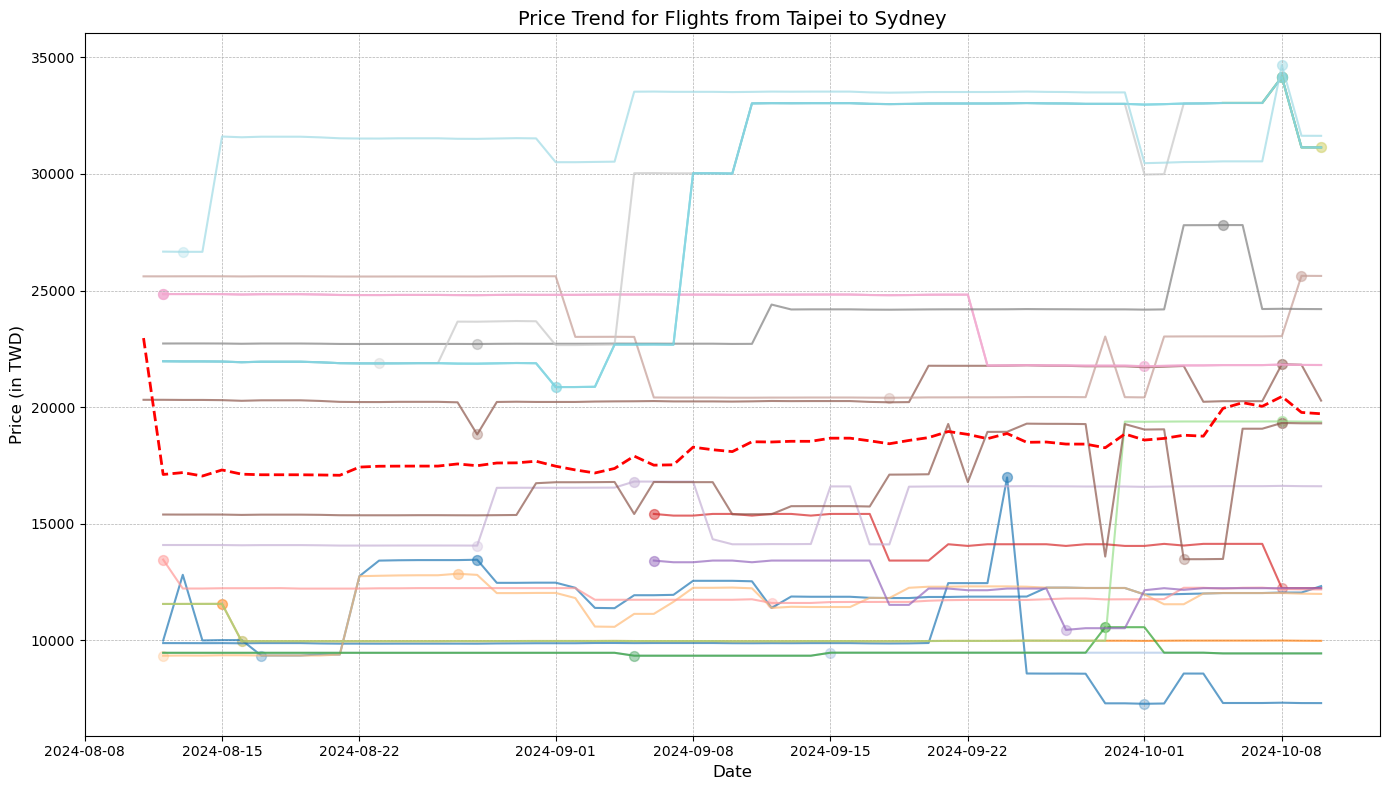

In [65]:
# 看歷史價格
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np

# Load the CSV file
filtered_data = pd.read_csv('google_flights_data_syd_1220_filtered.csv')

# 創建一個空字典來存放每個航班的價格歷史
price_trends = {}
all_prices = []

# 處理每個航班的價格歷史
for index, row in filtered_data.iterrows():
    flight_code = row['航班代碼']
    price_history = row['價格歷史']
    
    if pd.isna(price_history):
        continue  # 跳過沒有價格歷史的航班
    
    # 定義提取價格的函數
    def extract_prices(price_history):
        if isinstance(price_history, str):  # 確保數據是字串
            # 使用正則表達式提取價格，匹配格式「月/日 - $價錢」
            return re.findall(r'(\d{2}/\d{2}) - \$(\d+,\d+|\d+)', price_history)
        return []

    # 提取日期和價格
    matches = extract_prices(price_history)
    
    if matches:
        dates = []
        prices = []
        for match in matches:
            date_str, price = match
            price = int(price.replace(",", ""))  # 去除價格中的逗號並轉為整數
            
            # 假設年份為 2024，轉換日期格式
            date = datetime.strptime(f"2024/{date_str}", "%Y/%m/%d")
            dates.append(date)  # 儲存日期
            prices.append(price)  # 儲存價格
        
        # 儲存價格趨勢
        price_trends[flight_code] = (np.array(dates), np.array(prices))
        all_prices.extend(prices)  # 把每個航班的價格加到總體價格列表中

# 繪製價格趨勢圖
plt.figure(figsize=(14, 8))

# 使用 'tab20' 顏色映射
colors = plt.get_cmap('tab20', len(price_trends))

for idx, (flight_code, (dates, prices)) in enumerate(price_trends.items()):
    # 獲取顏色
    line_color = colors(idx / (len(price_trends) - 1))

    # 繪製價格趨勢
    plt.plot(dates, prices, color=line_color, label=flight_code, lw=1.5, alpha=0.7)

    # 找到每個航班的最低點和最高點
    min_price = np.min(prices)
    max_price = np.max(prices)
    min_date = dates[np.argmin(prices)]
    max_date = dates[np.argmax(prices)]
    
    # 用與航班趨勢線相同的顏色標記最低點和最高點
    plt.scatter(min_date, min_price, color=line_color, marker='o', s=50, alpha=0.3)  # 最低點
    plt.scatter(max_date, max_price, color=line_color, marker='o', s=50, alpha=0.5)  # 最高點

# 計算各日期的平均最低價格
all_dates = sorted(list(set([date for dates, prices in price_trends.values() for date in dates])))
mean_prices = []

for date in all_dates:
    daily_prices = []
    for flight_code, (dates, prices) in price_trends.items():
        # 檢查日期是否存在於航班的日期中，並安全提取價格
        if date in dates:
            idx = np.where(dates == date)[0]
            if len(idx) > 0:
                daily_prices.append(prices[idx[0]])
    
    if daily_prices:  # 如果當天有價格數據
        mean_prices.append(sum(daily_prices) / len(daily_prices))

# 繪製平均最低價格趨勢
plt.plot(all_dates, mean_prices, 'r--', label="Mean Lowest Price", lw=2)

# 設定圖表標題和軸標籤
plt.title("Price Trend for Flights from Taipei to Sydney", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (in TWD)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# 美化圖形
plt.tight_layout()

# 顯示圖表
plt.show()

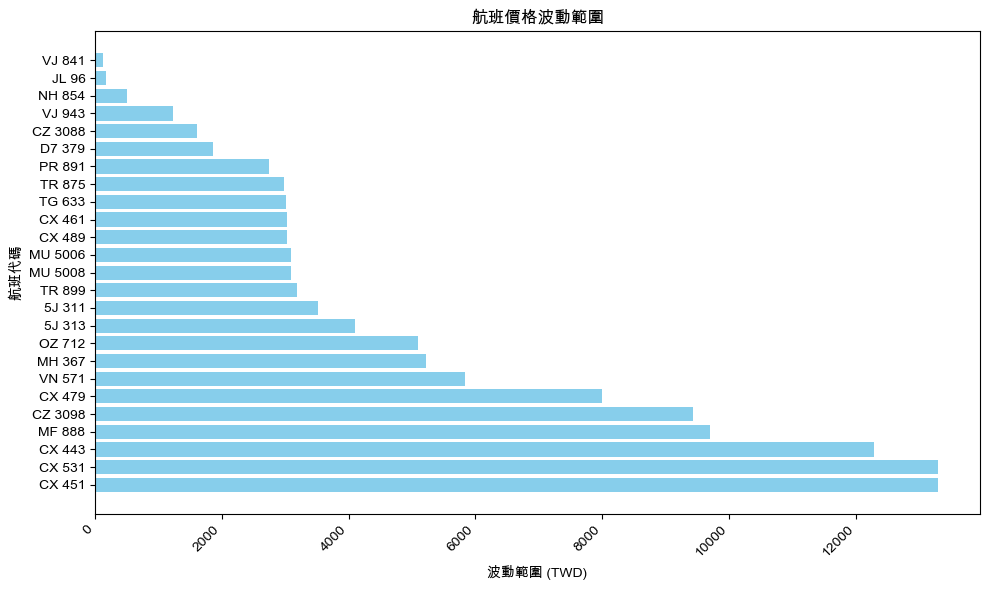

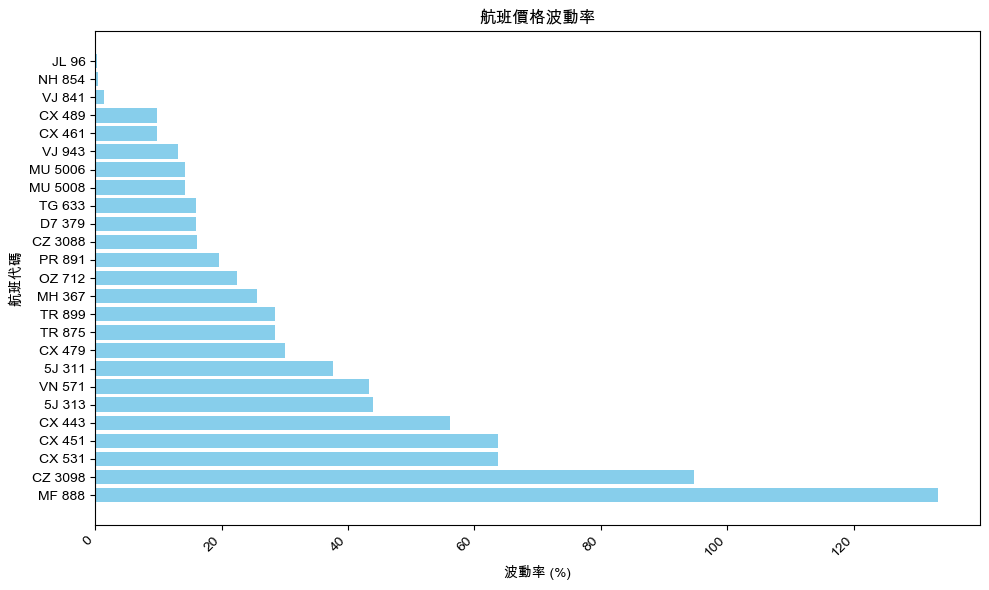

In [90]:
# 看波動
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np
from matplotlib import font_manager

plt.rcParams['font.family'] = 'Arial Unicode MS'  # 或 'PingFang TC'

# Load the CSV file
filtered_data = pd.read_csv('google_flights_data_syd_1220_filtered.csv')

# 創建一個空字典來存放每個航班的價格歷史
price_trends = {}
all_prices = []
flight_data = []

# 處理每個航班的價格歷史
for index, row in filtered_data.iterrows():
    flight_code = row['航班代碼']
    price_history = row['價格歷史']
    
    if pd.isna(price_history):
        continue  # 跳過沒有價格歷史的航班
    
    # 定義提取價格的函數
    def extract_prices(price_history):
        if isinstance(price_history, str):  # 確保數據是字串
            # 使用正則表達式提取價格，匹配格式「月/日 - $價錢」
            return re.findall(r'(\d{2}/\d{2}) - \$(\d+,\d+|\d+)', price_history)
        return []

    # 提取日期和價格
    matches = extract_prices(price_history)
    
    if matches:
        dates = []
        prices = []
        for match in matches:
            date_str, price = match
            price = int(price.replace(",", ""))  # 去除價格中的逗號並轉為整數
            
            # 假設年份為 2024，轉換日期格式
            date = datetime.strptime(f"2024/{date_str}", "%Y/%m/%d")
            dates.append(date)  # 儲存日期
            prices.append(price)  # 儲存價格
        
        # 儲存價格趨勢
        price_trends[flight_code] = (np.array(dates), np.array(prices))
        all_prices.extend(prices)  # 把每個航班的價格加到總體價格列表中

        # 找到每個航班的最低點和最高點
        min_price = np.min(prices)
        max_price = np.max(prices)
        min_date = dates[np.argmin(prices)]
        max_date = dates[np.argmax(prices)]
        
        # 存入航班價格數據
        flight_data.append({
            "航班代碼": flight_code,
            "最低價日期": min_date.strftime('%Y-%m-%d'),
            "最低價": min_price,
            "最高價日期": max_date.strftime('%Y-%m-%d'),
            "最高價": max_price
        })

# 將資料轉換為 DataFrame
df = pd.DataFrame(flight_data)

# 計算價格波動範圍
df['波動範圍'] = df['最高價'] - df['最低價']

# 計算波動率（相對於最低價的百分比）
df['波動率 (%)'] = (df['波動範圍'] / df['最低價']) * 100

# 按照波動範圍排序
df_sorted = df.sort_values(by='波動範圍', ascending=False)

# 如果需要可視化，可以根據波動範圍繪製圖表
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['航班代碼'], df_sorted['波動範圍'], color='skyblue')
plt.xlabel('波動範圍 (TWD)')
plt.ylabel('航班代碼')
plt.title('航班價格波動範圍')
plt.xticks(rotation=45, ha='right')  # 讓航班代碼可讀
plt.tight_layout()
plt.show()

# 顯示波動率
df_sorted = df.sort_values(by='波動率 (%)', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df_sorted['航班代碼'], df_sorted['波動率 (%)'], color='skyblue')
plt.xlabel('波動率 (%)')
plt.ylabel('航班代碼')
plt.title('航班價格波動率')
plt.xticks(rotation=45, ha='right')  # 讓航班代碼可讀
plt.tight_layout()
plt.show()